In [101]:
import pandas_datareader as web
import numpy as np

In [102]:
def download_daily_data(symbol, start, end):
    """
    The function download daily stock data from Yahoo finance to pandas Dataframe 
    using Pandas_datareader module https://pandas-datareader.readthedocs.io/en/latest/
    between the dates specified.
    """
    try: 
        df = web.DataReader(symbol,"yahoo", start, end)
        print(f"Data for symbol {symbol} was downloaded sucessfully!")
    except:
        print(f"There is some error for symbol {symbol} with data download")
        
    return df
    
def compute_dail_returns(data):
    """
    The function computes daily log returns based on the Close prices in the pandas
    DataFrame and stores it in column cc_returns.
    """
    data["cc_returns"] = np.log(data["Close"] / data["Close"].shift(1))
    return data


def compute_indicators(data):
    """
    This function creates additional columns to OHLC data in pandas DataFrame
    required to backtest the "Big Moves on Mondays" trading strategy.
    """
    # Condition 1
    data["day"] = data.index.day_name()
    data["prev_day"] = data["day"].shift(1)
    data["four_days_after"] = data["day"].shift(-4)
    
    # Condition 2 
    data["realtive_range"] = (data["High"] - data["Low"]) / data["Close"] 
    data["rel_range_ma"] =  data["realtive_range"].rolling(window=25).mean()
    
    # Condition 3 
    data["ibs"] = (data["Close"] - data["Low"]) / (data["High"] - data["Low"])
    
    return data
    
def backtest_strategy(data):
    """
    The function computes additional columns in the pandas DataFrame 
    for checking conditions to backtest the "Big Moves on Mondays" trading strategy.
    It computes the strategy returns then
    """
    data["condition1"] = np.where( (data["day"] == "Monday")
                                  & (data["prev_day"] == "Friday")
                                  & (data["four_days_after"] == "Friday"),
                                  1,0)

    data["condition2"] = np.where( (1-data["Close"] / data["Close"].shift(1))
                                  >= 0.25 * data["rel_range_ma"],1,0)


    data["condition3"] = np.where( data["ibs"] < 0.3, 1, 0)

    # All three conditions above are True
    valid_signal = (data["condition1"]==1) & (data["condition2"]==1) & (data["condition3"]==1)
    # Place Trading signal                           
    data["signal"] = np.where(valid_signal,1,0)

    # Calculate correctly positions and strategy returns
    # Shift "impulse" trading signal to next bar -> trade entry 1 bar after signal
    data["signal"] = data["signal"].shift(1)

    # Convert "impulse signal to "state" signal: 1== IN Position, 0== FLAT Position
    data["position"] = data["signal"].replace(to_replace=0, method="ffill", limit=3)

    # Calculate strategy returns
    data["strategy_returns"] = data["cc_returns"] * data["position"]

    return data

def show_backtesting_results(data):
    """
    The function displays the cummulative returns from trading strategy and buy&hold strategy.
    It also plots a chart showing both returns and position over time.
    IMPORTANT: To be run only after the function backtest_strategy!!
    """    
    print("Buy & Hold Returns: ",np.round(data["cc_returns"].cumsum()[-1],2))
    print("Strategy Returns: ",np.round(data["strategy_returns"].cumsum()[-1],2))
    
    data[["cc_returns","strategy_returns"]] = data[["cc_returns","strategy_returns"]].cumsum()
    data[["cc_returns","strategy_returns","position"]].plot(secondary_y="position", grid = True, figsize=(12,8)) 

In [113]:
ticker = download_daily_data("XLE", "1/1/2000", "1/1/2020")

Data for symbol XLE was downloaded sucessfully!


In [114]:
df2 = compute_dail_returns(ticker)

In [115]:
df2 = compute_indicators(df2)

In [116]:
df2 = backtest_strategy(df2) 

Buy & Hold Returns:  0.82
Strategy Returns:  1.78


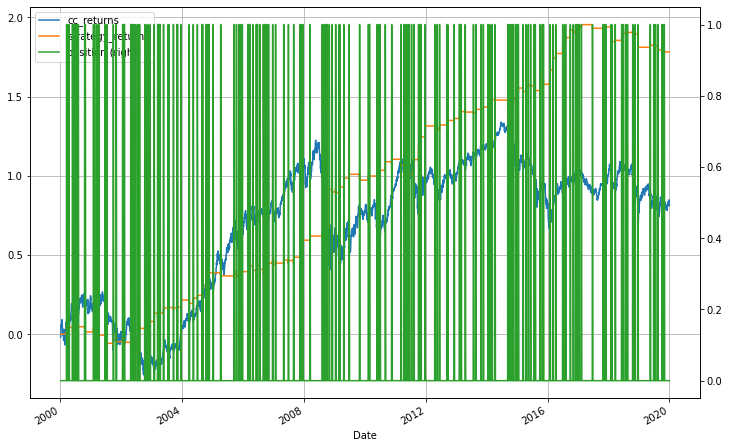

In [117]:
show_backtesting_results(df2)